In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt


In [28]:
repo_url = "https://raw.githubusercontent.com/Alejandra-LozC/dti_alps/main/alps_v3.csv"

try:
    print("Upload from GitHub...")
    df = pd.read_csv(repo_url, decimal=',', sep=None, engine='python')
    print(df.head())
except Exception as e:
    print(f"No file: {e}")

Upload from GitHub...
        id  session    group       tx abstinence  x_proj_L  x_assoc_L  \
0  sub-001        1  control  control    control  0.000432   0.000504   
1  sub-002        1  control  control    control  0.000420   0.000473   
2  sub-004        1  control  control    control  0.000412   0.000485   
3  sub-005        1  control  control    control  0.000435   0.000440   
4  sub-006        1  control  control    control  0.000474   0.000553   

   y_proj_L  z_assoc_L  x_proj_R  x_assoc_R  y_proj_R  z_assoc_R    alps_L  \
0  0.000322   0.000340  0.000427   0.000521  0.000348   0.000359  1.413897   
1  0.000339   0.000313  0.000396   0.000499  0.000316   0.000285  1.369632   
2  0.000381   0.000339  0.000425   0.000477  0.000340   0.000284  1.245833   
3  0.000314   0.000249  0.000431   0.000437  0.000307   0.000275  1.554174   
4  0.000280   0.000417  0.000423   0.000578  0.000352   0.000421  1.473458   

     alps_R      alps  
0  1.340877  1.377387  
1  1.489185  1.429408 

In [29]:
def format_val(val, decimals):
    return f"{val:.{decimals}f}"

col_group = 'group'
col_session = 'session'
col_abst = 'abstinence'
col_value = 'alps'

print("=== DATA PREPARATION (SESSION 1) ===")

# Filter for Session 1
df_s1 = df[df[col_session] == 1].copy()
df_s1['abstinence_num'] = pd.to_numeric(df_s1[col_abst], errors='coerce')
mask_control = df_s1[col_group] == 'control'
mask_alcohol = df_s1[col_group] == 'alcohol'

# ==========================================
# SUBGROUPS AND COMPARISONS
# ==========================================
comparisons = [
    {
        "name": "1. Control vs Alcohol (Total)",
        "g1_mask": mask_control,
        "g2_mask": mask_alcohol
    },
    {
        "name": "2. Control vs Abst <= 6",
        "g1_mask": mask_control,
        "g2_mask": (mask_alcohol) & (df_s1['abstinence_num'] <= 6)
    },
    {
        "name": "3. Control vs Abst >= 6",
        "g1_mask": mask_control,
        "g2_mask": (mask_alcohol) & (df_s1['abstinence_num'] >= 6)
    },
    {
        "name": "4. Control vs Abst <= 2",
        "g1_mask": mask_control,
        "g2_mask": (mask_alcohol) & (df_s1['abstinence_num'] <= 2)
    },
    {
        "name": "5. Control vs Abst >= 2",
        "g1_mask": mask_control,
        "g2_mask": (mask_alcohol) & (df_s1['abstinence_num'] >= 2)
    }
]

# Variables to analyze
variables = ['alps', 'alps_L', 'alps_R']
variables += ['x_proj_L', 'x_assoc_L', 'y_proj_L', 'z_assoc_L', 'x_proj_R', 'x_assoc_R', 'y_proj_R', 'z_assoc_R']

# ==========================================
# STATISTICAL ANALYSIS LOOP
# ==========================================
results = []

print(f"Analyzing {len(variables)} variables across {len(comparisons)} comparisons...")

for v in variables:
    df_s1[v] = pd.to_numeric(df_s1[v], errors='coerce')

for var in variables:
    for comp in comparisons:
        # A) Extract Data (now numeric)
        data_c = df_s1.loc[comp['g1_mask'], var].dropna().astype(float)   # Control Group (Reference)
        data_alc = df_s1.loc[comp['g2_mask'], var].dropna().astype(float) # Alcohol Group

        # Sample size
        n_c, n_alc = len(data_c), len(data_alc)
        if n_c < 2 or n_alc < 2:
            continue

        # B) Mann-Whitney U (Non-parametric)
        u_stat, p_u = stats.mannwhitneyu(data_c.values, data_alc.values)

        # C) T-Test (Welch's)
        t_stat, p_t = stats.ttest_ind(data_c.values, data_alc.values, equal_var=False)

        # D) Cohen's d (Effect Size)
        mean_c, mean_alc = data_c.mean(), data_alc.mean()
        sd_c, sd_alc = data_c.std(ddof=1), data_alc.std(ddof=1)

        # Pooled SD Calculation
        if (n_c + n_alc - 2) > 0 and (n_c > 1 and n_alc > 1):
            sd_pooled = np.sqrt(((n_c - 1) * sd_c**2 + (n_alc - 1) * sd_alc**2) / (n_c + n_alc - 2))
        else:
            sd_pooled = np.nan

        # Avoid division by zero
        if pd.isna(sd_pooled) or sd_pooled == 0:
            cohen_d = 0.0
        else:
            cohen_d = (mean_c - mean_alc) / sd_pooled

        def get_sig_stars(p):
            if p < 0.001: return '***'
            elif p < 0.01: return '**'
            elif p < 0.05: return '*'
            else: return ''

        p_min = min(p_u, p_t)
        sig_label = get_sig_stars(p_min)

        results.append({
            'Variable': var,
            'Comparison': comp['name'],
            'N (Ctrl/Alc)': f"{n_c}/{n_alc}",
            'Mean Ctrl': format_val(mean_c, 5),
            'Mean Alc': format_val(mean_alc, 5),
            'P-Val (M-W)': format_val(p_u, 5),
            'P-Val (T-T)': format_val(p_t, 5),
            'Cohen\'s d': round(cohen_d, 4),
            'Sig?': sig_label
        })

# ==========================================
# DISPLAY RESULTS TABLE
# ==========================================
res_df = pd.DataFrame(results)
print("\n=== DETAILED STATISTICAL SUMMARY ===")

try:
    from tabulate import tabulate
    for var in variables:
        print(f"\n--- Results for: {var} ---")
        subset = res_df[res_df['Variable'] == var].drop(columns=['Variable'])
        print(tabulate(subset, headers='keys', tablefmt='github', showindex=False))
except ImportError:
    print(res_df)

=== DATA PREPARATION (SESSION 1) ===
Analyzing 11 variables across 5 comparisons...

=== DETAILED STATISTICAL SUMMARY ===

--- Results for: alps ---
| Comparison                    | N (Ctrl/Alc)   |   Mean Ctrl |   Mean Alc |   P-Val (M-W) |   P-Val (T-T) |   Cohen's d | Sig?   |
|-------------------------------|----------------|-------------|------------|---------------|---------------|-------------|--------|
| 1. Control vs Alcohol (Total) | 25/40          |     1.47137 |    1.38734 |       0.0762  |       0.02317 |      0.582  | *      |
| 2. Control vs Abst <= 6       | 25/22          |     1.47137 |    1.4128  |       0.28163 |       0.11965 |      0.4595 |        |
| 3. Control vs Abst >= 6       | 25/21          |     1.47137 |    1.36545 |       0.06086 |       0.02883 |      0.6876 | *      |
| 4. Control vs Abst <= 2       | 25/10          |     1.47137 |    1.44751 |       0.98543 |       0.47811 |      0.1991 |        |
| 5. Control vs Abst >= 2       | 25/40          |   

In [31]:
from IPython.display import display

# ==========================================
# SUMMARY OF SIGNIFICANT FINDINGS
# ==========================================
sig_findings = res_df[res_df['Sig?'] != ''].copy()

if not sig_findings.empty:
    print("\n[!] SIGNIFICANT FINDINGS FOUND:")
    styled_sig = sig_findings.style.set_properties(**{'text-align': 'left'})\
                            .set_table_styles([{'selector': 'th', 'props': [('background-color', '#f4f4f4')]}])
    display(styled_sig)
else:
    print("\n[i] No significant differences found with p < 0.05")
    display(res_df.head(5))


[!] SIGNIFICANT FINDINGS FOUND:


,Variable,Comparison,N (Ctrl/Alc),Mean Ctrl,Mean Alc,P-Val (M-W),P-Val (T-T),Cohen's d,Sig?
0,alps,1. Control vs Alcohol (Total),25/40,1.47137,1.38734,0.07620,0.02317,0.582000,*
2,alps,3. Control vs Abst >= 6,25/21,1.47137,1.36545,0.06086,0.02883,0.687600,*
4,alps,5. Control vs Abst >= 2,25/40,1.47137,1.38734,0.07620,0.02317,0.582000,*
5,alps_L,1. Control vs Alcohol (Total),25/40,1.50478,1.40251,0.03258,0.01362,0.658300,*
7,alps_L,3. Control vs Abst >= 6,25/21,1.50478,1.38268,0.01941,0.01773,0.736800,*
9,alps_L,5. Control vs Abst >= 2,25/40,1.50478,1.40251,0.03258,0.01362,0.658300,*
30,z_assoc_L,1. Control vs Alcohol (Total),25/40,0.00032,0.00034,0.04037,0.03192,-0.545800,*
32,z_assoc_L,3. Control vs Abst >= 6,25/21,0.00032,0.00035,0.05501,0.04327,-0.627100,*
34,z_assoc_L,5. Control vs Abst >= 2,25/40,0.00032,0.00034,0.04037,0.03192,-0.545800,*


Generando Gráfico 1 con significancia...


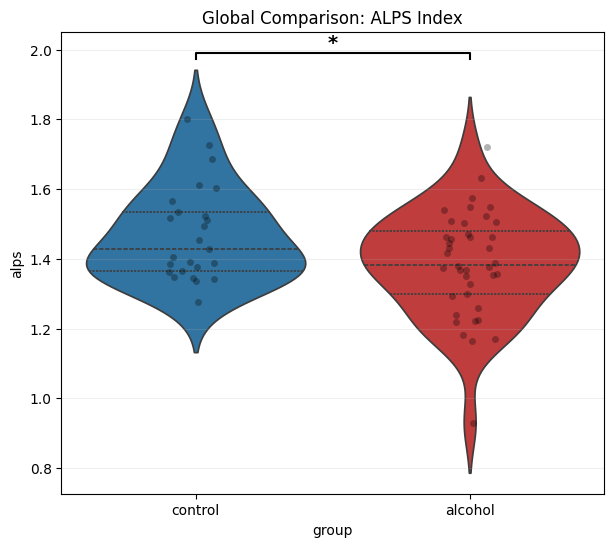

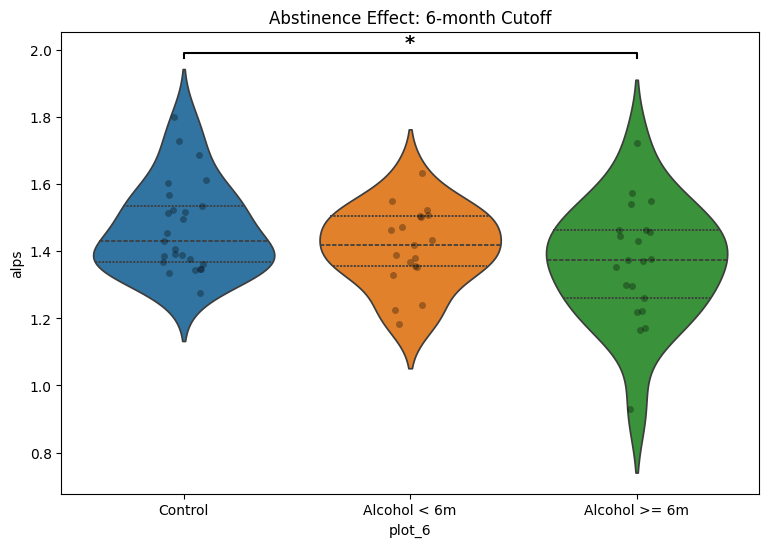

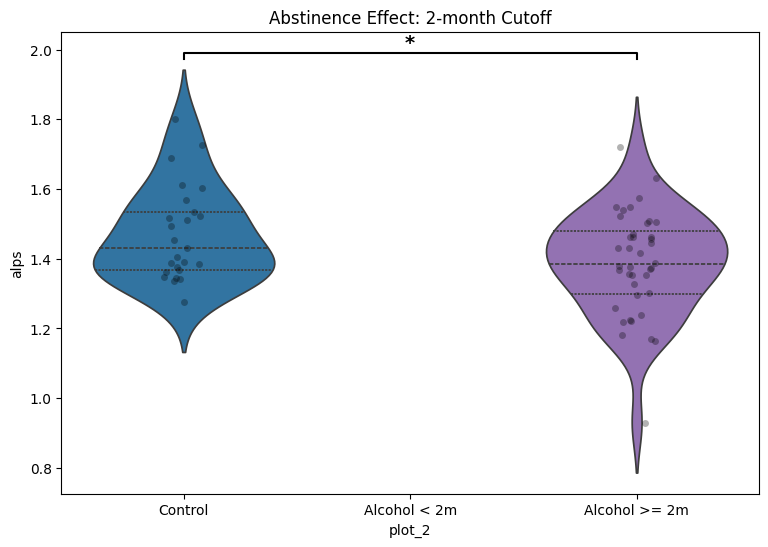

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

COLOR_PALETTE = {
    'Control': '#1f77b4',
    'control': '#1f77b4',
    'Alcohol': '#d62728',
    'alcohol': '#d62728',
    'Alcohol < 6m': '#ff7f0e',
    'Alcohol >= 6m': '#2ca02c',
    'Alcohol < 2m': '#e377c2',
    'Alcohol >= 2m': '#9467bd'
}

def add_stat_annotation(ax, x1, x2, p_val, y_max, total_height):
    """Dibuja el corchete y las estrellas de significancia"""
    if p_val >= 0.05:
        return
    if p_val < 0.001: stars = "***"
    elif p_val < 0.01: stars = "**"
    else: stars = "*"

    # Line
    y = y_max + (total_height * 0.2)
    h = total_height * 0.02
    
    # Black line
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    # Stars
    ax.text((x1+x2)*.5, y+h, stars, ha='center', va='bottom', color='black', 
            fontsize=14, fontweight='bold')

# ==========================================
# DATA
# ==========================================
df_s1 = df[df['session'] == 1].copy()
df_s1['abst_num'] = pd.to_numeric(df_s1['abstinence'], errors='coerce')

# --- PLOT 1: Control vs Alcohol ---
print("Generando Gráfico 1 con significancia...")
plt.figure(figsize=(7, 6))
ax1 = sns.violinplot(data=df_s1, x='group', y='alps', hue='group', 
                    palette=COLOR_PALETTE, inner="quart", legend=False)
sns.stripplot(data=df_s1, x='group', y='alps', color='black', alpha=0.3)
y_max_global = df_s1['alps'].max()
h_global = y_max_global - df_s1['alps'].min()
add_stat_annotation(ax1, 0, 1, 0.02317, y_max_global, h_global)

plt.title('Global Comparison: ALPS Index')
plt.grid(axis='y', alpha=0.2)
plt.show()

# --- PLOT 2: ABSTINENCE (6-month Cutoff) ---
conditions_6 = [
    (df_s1['group'] == 'control'),
    (df_s1['group'] == 'alcohol') & (df_s1['abst_num'] < 6),
    (df_s1['group'] == 'alcohol') & (df_s1['abst_num'] >= 6)
]
choices_6 = ['Control', 'Alcohol < 6m', 'Alcohol >= 6m']
df_s1['plot_6'] = np.select(conditions_6, choices_6, default=None)
df_p6 = df_s1.dropna(subset=['plot_6'])
order_6 = ['Control', 'Alcohol < 6m', 'Alcohol >= 6m']

plt.figure(figsize=(9, 6))
ax2 = sns.violinplot(data=df_p6, x='plot_6', y='alps', order=order_6, 
                    hue='plot_6', palette=COLOR_PALETTE, inner="quart", legend=False)
sns.stripplot(data=df_p6, x='plot_6', y='alps', order=order_6, color='black', alpha=0.3)

# Control vs >= 6m: p = 0.02883 (*)
y_max_6 = df_p6['alps'].max()
h_6 = y_max_6 - df_p6['alps'].min()
add_stat_annotation(ax2, 0, 2, 0.02883, y_max_6, h_6)

plt.title('Abstinence Effect: 6-month Cutoff')
plt.show()

# --- PLOT 3: ABSTINENCE (2-month Cutoff) ---
conditions_2 = [
    (df_s1['group'] == 'control'),
    (df_s1['group'] == 'alcohol') & (df_s1['abst_num'] < 2),
    (df_s1['group'] == 'alcohol') & (df_s1['abst_num'] >= 2)
]
choices_2 = ['Control', 'Alcohol < 2m', 'Alcohol >= 2m']
df_s1['plot_2'] = np.select(conditions_2, choices_2, default=None)
df_p2 = df_s1.dropna(subset=['plot_2'])
order_2 = ['Control', 'Alcohol < 2m', 'Alcohol >= 2m']

plt.figure(figsize=(9, 6))
ax3 = sns.violinplot(data=df_p2, x='plot_2', y='alps', order=order_2, 
                    hue='plot_2', palette=COLOR_PALETTE, inner="quart", legend=False)
sns.stripplot(data=df_p2, x='plot_2', y='alps', order=order_2, color='black', alpha=0.3)

# Control vs >= 2m: p = 0.02317 (*)
y_max_2 = df_p2['alps'].max()
h_2 = y_max_2 - df_p2['alps'].min()
add_stat_annotation(ax3, 0, 2, 0.02317, y_max_2, h_2)

plt.title('Abstinence Effect: 2-month Cutoff')
plt.show()

In [33]:
# ==========================================
# ANCOVA MODEL PREPARATION AND ANALYSIS
# ==========================================

print("=== PREPARING DATA FOR ANCOVA MODEL ===")

# Prepare the data for ANCOVA
df_session1 = df[df['session'] == 1][['id', 'group', 'alps']].copy()
df_session2 = df[df['session'] == 2][['id', 'group', 'alps']].copy()

# Rename columns
df_session1 = df_session1.rename(columns={'alps': 'Sesion1'})
df_session2 = df_session2.rename(columns={'alps': 'Sesion2'})

# Merge sessions to get paired data
df_ancova = pd.merge(df_session1, df_session2, on=['id', 'group'], how='inner')
df_ancova['group'] = df_ancova['group'].map({'control': 0, 'alcohol': 1})

# Remove any rows with missing values
df_ancova = df_ancova.dropna(subset=['Sesion1', 'Sesion2', 'group'])

print(f"ANCOVA dataset prepared:")
print(f"- Total subjects with both sessions: {len(df_ancova)}")
print(f"- Control group: {len(df_ancova[df_ancova['group'] == 0])}")
print(f"- Alcohol group: {len(df_ancova[df_ancova['group'] == 1])}")
print(f"- Columns: {list(df_ancova.columns)}")

# ==========================================
# ANCOVA MODEL
# ==========================================

print("\n=== RUNNING ANCOVA MODEL ===")

# Fit the ANCOVA model
model = smf.ols('Sesion2 ~ C(group) + Sesion1', data=df_ancova).fit()

# Display results
print("\nANCOVA Results:")
print("=" * 60)
print(model.summary())

# ==========================================
# EXTRACT KEY STATISTICS
# ==========================================

print("\n=== KEY STATISTICS SUMMARY ===")

# Extract key values
treatment_effect = model.params['C(group)[T.1]']
treatment_pvalue = model.pvalues['C(group)[T.1]']
covariate_effect = model.params['Sesion1']
covariate_pvalue = model.pvalues['Sesion1']
r_squared = model.rsquared
adj_r_squared = model.rsquared_adj

print(f"Treatment Effect (Alcohol vs Control): {treatment_effect:.4f}")
print(f"Treatment P-value: {treatment_pvalue:.4f}")
print(f"Baseline Covariate Effect: {covariate_effect:.4f}")
print(f"Baseline P-value: {covariate_pvalue:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"Adjusted R-squared: {adj_r_squared:.4f}")

# Significance interpretation
def get_significance(p_value):
    if p_value < 0.001:
        return "*** (p < 0.001)"
    elif p_value < 0.01:
        return "** (p < 0.01)"
    elif p_value < 0.05:
        return "* (p < 0.05)"
    else:
        return "ns (not significant)"

print(f"\nTreatment Effect Significance: {get_significance(treatment_pvalue)}")
print(f"Baseline Covariate Significance: {get_significance(covariate_pvalue)}")



=== PREPARING DATA FOR ANCOVA MODEL ===
ANCOVA dataset prepared:
- Total subjects with both sessions: 42
- Control group: 10
- Alcohol group: 32
- Columns: ['id', 'group', 'Sesion1', 'Sesion2']

=== RUNNING ANCOVA MODEL ===

ANCOVA Results:
                            OLS Regression Results                            
Dep. Variable:                Sesion2   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     39.46
Date:                Wed, 14 Jan 2026   Prob (F-statistic):           4.26e-10
Time:                        14:54:42   Log-Likelihood:                 44.562
No. Observations:                  42   AIC:                            -83.12
Df Residuals:                      39   BIC:                            -77.91
Df Model:                           2                                         
Covariance Type:            nonrobust           


=== GENERATING VISUALIZATIONS ===


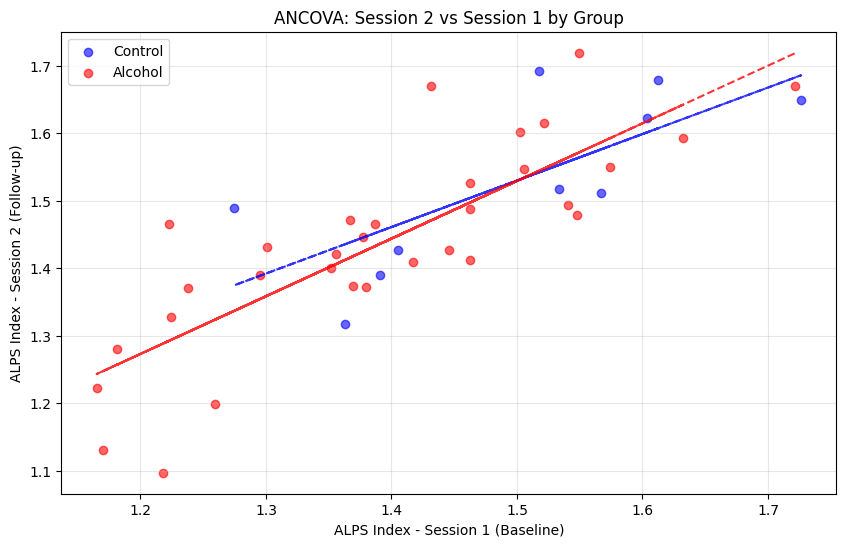

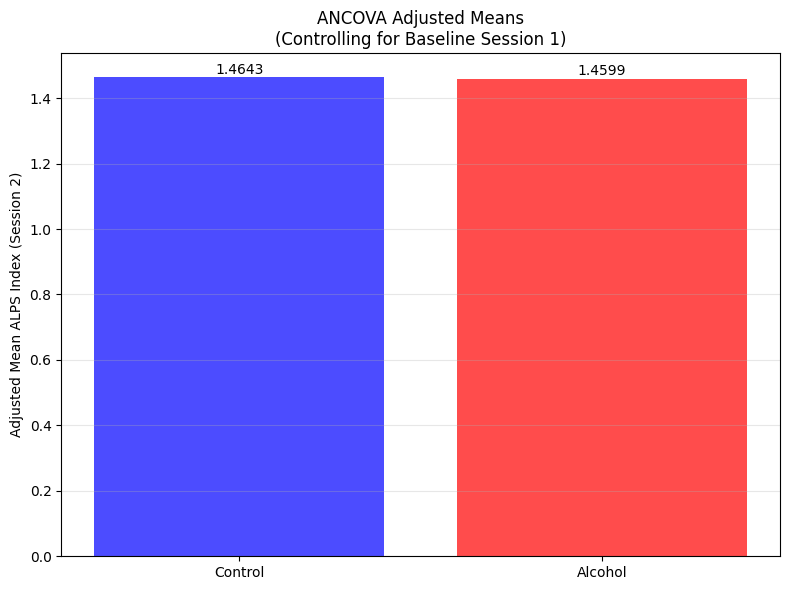

In [34]:
# ==========================================
# VISUALIZATIONS
# ==========================================

print("\n=== GENERATING VISUALIZATIONS ===")

# Scatter plot with regression lines
plt.figure(figsize=(10, 6))
colors = ['blue', 'red']
groups = [0, 1]
group_names = ['Control', 'Alcohol']

for i, group in enumerate(groups):
    group_data = df_ancova[df_ancova['group'] == group]
    plt.scatter(group_data['Sesion1'], group_data['Sesion2'], 
            color=colors[i], alpha=0.6, label=group_names[i])
    
    # Add regression line for each group
    z = np.polyfit(group_data['Sesion1'], group_data['Sesion2'], 1)
    p = np.poly1d(z)
    plt.plot(group_data['Sesion1'], p(group_data['Sesion1']), 
            color=colors[i], linestyle='--', alpha=0.8)

plt.xlabel('ALPS Index - Session 1 (Baseline)')
plt.ylabel('ALPS Index - Session 2 (Follow-up)')
plt.title('ANCOVA: Session 2 vs Session 1 by Group')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Adjusted means (controlling for baseline)
plt.figure(figsize=(8, 6))

# Calculate adjusted means
baseline_mean = df_ancova['Sesion1'].mean()
intercept = model.params['Intercept']
treatment_effect = model.params['C(group)[T.1]']
covariate_effect = model.params['Sesion1']

adj_mean_control = intercept + covariate_effect * baseline_mean
adj_mean_alcohol = intercept + treatment_effect + covariate_effect * baseline_mean

groups = ['Control', 'Alcohol']
adj_means = [adj_mean_control, adj_mean_alcohol]

plt.bar(groups, adj_means, color=['blue', 'red'], alpha=0.7)
plt.ylabel('Adjusted Mean ALPS Index (Session 2)')
plt.title('ANCOVA Adjusted Means\n(Controlling for Baseline Session 1)')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, mean in enumerate(adj_means):
    plt.text(i, mean + 0.001, f'{mean:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [9]:
df_ancova

,id,group,Sesion1,Sesion2
0,sub-03,0,1.390981,1.390000
1,sub-06,0,1.567034,1.511377
2,sub-09,0,1.533166,1.516999
3,sub-10,0,1.274884,1.489254
4,sub-11,0,1.726452,1.648331
5,sub-12,0,1.517179,1.692361
6,sub-13,0,1.612513,1.678707
7,sub-15,0,1.603504,1.622993
8,sub-16,1,1.721243,1.669185
9,sub-17,1,1.238230,1.370487


In [11]:
print("\n=== DATA PREP FOR ANCOVA ===")

# Session filter
df_session1 = df[df['session'] == 1][['id', 'tx', 'alps']].copy()
df_session2 = df[df['session'] == 2][['id', 'tx', 'alps']].copy()

# Rename sessions
df_session1 = df_session1.rename(columns={'alps': 'Sesion1'})
df_session2 = df_session2.rename(columns={'alps': 'Sesion2'})

# Just subjects with BOTH sessions
df_ancova = pd.merge(df_session1[['id', 'Sesion1']], 
                    df_session2[['id', 'Sesion2', 'tx']], 
                    on='id', how='inner')

# Mapping treatment
mapping = {'active': 0, 'sham': 1}
df_ancova['tx_num'] = df_ancova['tx'].map(mapping)

# NaNs no no
df_ancova = df_ancova.dropna(subset=['Sesion1', 'Sesion2', 'tx_num'])

print(f"Subject with both sessions: {len(df_ancova)}")
print(f"- Active group: {len(df_ancova[df_ancova['tx_num'] == 0])}")
print(f"- Sham group: {len(df_ancova[df_ancova['tx_num'] == 1])}")

# ==========================================
# ANCOVA
# ==========================================
if len(df_ancova) > 0:
    print("\n=== ANCOVA MODEL ===")
    model = smf.ols('Sesion2 ~ C(tx_num) + Sesion1', data=df_ancova).fit()
    print(model.summary())

    # ==========================================
    # STATISTICS EXTRACTION
    # ==========================================
    param_names = list(model.params.index)
    treat_param = next((n for n in param_names if 'tx_num' in n and 'T.1' in n), None)
    cov_param = 'Sesion1'

    if treat_param and cov_param:
        t_eff = model.params[treat_param]
        t_pval = model.pvalues[treat_param]
        
        print("\n=== KEY RESULTS ===")
        print(f"Treatment effect (Sham vs Active): {t_eff:.4f}")
        print(f"Treatment p Value: {t_pval:.4f}")
        print(f"R-squared: {model.rsquared:.4f}")


=== DATA PREP FOR ANCOVA ===
Subject with both sessions: 32
- Active group: 17
- Sham group: 15

=== ANCOVA MODEL ===
                            OLS Regression Results                            
Dep. Variable:                Sesion2   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     29.85
Date:                Wed, 14 Jan 2026   Prob (F-statistic):           9.13e-08
Time:                        14:47:20   Log-Likelihood:                 34.089
No. Observations:                  32   AIC:                            -62.18
Df Residuals:                      29   BIC:                            -57.78
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------


=== GENERATING VISUALIZATIONS ===


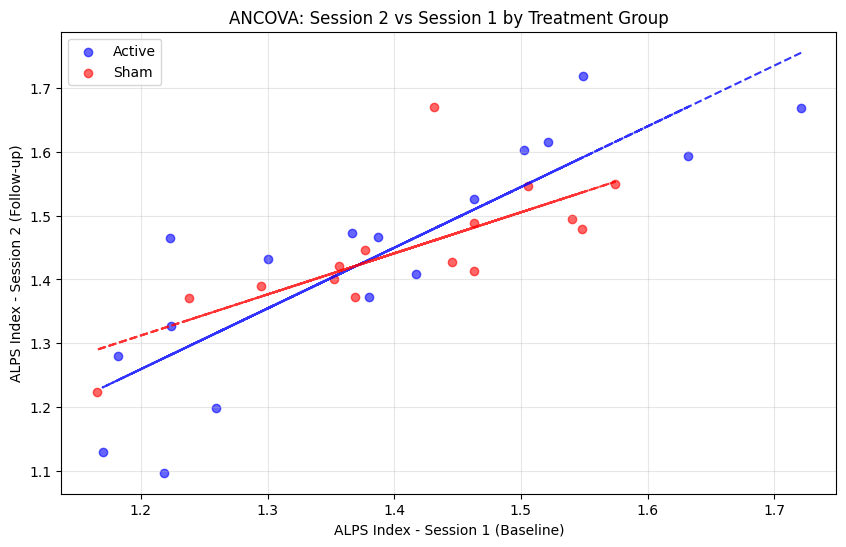

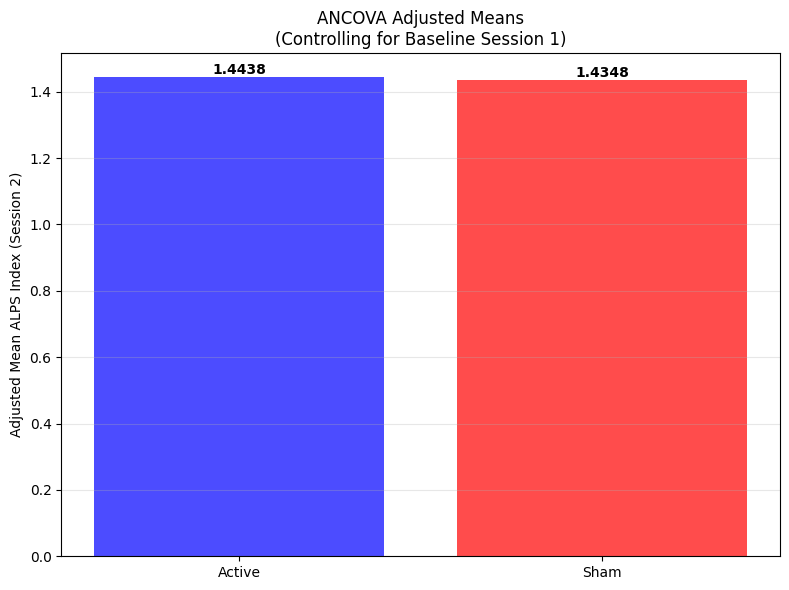

In [12]:
# ==========================================
# VISUALIZATIONS
# ==========================================

print("\n=== GENERATING VISUALIZATIONS ===")

# Scatter plot with regression lines
plt.figure(figsize=(10, 6))
colors = ['blue', 'red']
groups = [0, 1]
group_names = ['Active', 'Sham']

for i, group in enumerate(groups):
    group_data = df_ancova[df_ancova['tx_num'] == group]
    
    plt.scatter(group_data['Sesion1'], group_data['Sesion2'], 
                color=colors[i], alpha=0.6, label=group_names[i])

    if len(group_data) > 1:
        z = np.polyfit(group_data['Sesion1'], group_data['Sesion2'], 1)
        p = np.poly1d(z)
        plt.plot(group_data['Sesion1'], p(group_data['Sesion1']), 
                color=colors[i], linestyle='--', alpha=0.8)

plt.xlabel('ALPS Index - Session 1 (Baseline)')
plt.ylabel('ALPS Index - Session 2 (Follow-up)')
plt.title('ANCOVA: Session 2 vs Session 1 by Treatment Group')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Adjusted means (controlling for baseline)
plt.figure(figsize=(8, 6))

# Calculate adjusted means 
baseline_mean = df_ancova['Sesion1'].mean()
intercept = model.params['Intercept']
covariate_effect = model.params['Sesion1']
treatment_effect = model.params[treat_param] 

adj_mean_active = intercept + (covariate_effect * baseline_mean)
adj_mean_sham = intercept + treatment_effect + (covariate_effect * baseline_mean)

adj_means = [adj_mean_active, adj_mean_sham]

plt.bar(group_names, adj_means, color=['blue', 'red'], alpha=0.7)
plt.ylabel('Adjusted Mean ALPS Index (Session 2)')
plt.title('ANCOVA Adjusted Means\n(Controlling for Baseline Session 1)')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, mean in enumerate(adj_means):
    plt.text(i, mean + 0.001, f'{mean:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()